# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*



## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - **Model 0**: a transfer learning model using the Keras Functional API
  - **Model 1**: a feature extraction transfer learning model on 1% of the data with data augmentation
  - **Model 2**: a feature extraction transfer learning model on 10% of the data with data augmentation
  - **Model 3**: a fine-tuned transfer learning model on 10% of the data
  - **Model 4**: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


In [1]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

2025-01-26 09:47:26.423193: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 09:47:30.287573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 09:47:31.681274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 09:47:32.042137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 09:47:34.794941: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.17.0


In [2]:
# Are we using a GPU?
!nvidia-smi

Sun Jan 26 09:48:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:65:00.0 Off |                  N/A |
| N/A   50C    P3             11W /   66W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Creating helper functions

Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [3]:
# Get helper_functions.py script from course GitHub
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
import tensorflow as tf

log_dir = "logs/transfer_learning_part_2"

def create_tensorboard_callback(experiment_name, dir_name=log_dir):
    log_dir = dir_name + "/" + experiment_name
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## 10 Food Classes: Working with less data

We saw in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) which is part of the [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils) module.

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [ ]:
# Get 10% of the data of the 10 classes
# Download data (Skip, load the data locally)

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

In [6]:
food_classes_dir = "data/image_data/10_food_classes_10_percent"

# Walk through 10 percent data directory and list number of files
walk_through_dir(food_classes_dir)

There are 2 directories and 0 images in 'data/image_data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/image_data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/

We can see that each of the training directories contain 75 images and each of the testing directories contain 250 images.

Let's define our training and test filepaths.

In [ ]:
train_dir = food_classes_dir + "/train/"
test_dir = food_classes_dir + "/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class.

However, as of August 2023, this class is deprecated and isn't recommended for future usage (it's too slow).

Because of this, we'll move onto using `tf.keras.utils.image_dataset_from_directory()`.

This method expects image data in the following file format:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator.

The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

Let's see it in action.

In [8]:
# Create data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)  # define image size

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",  # what type are the labels?
    batch_size=32)  # batch_size is 32 by default, this is generally a good number

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.


I0000 00:00:1737856112.555111   40895 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737856116.583214   40895 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737856116.583274   40895 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737856116.593731   40895 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737856116.593782   40895 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 2500 files belonging to 10 classes.


Wonderful! Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` funtion are:
* `directory` - the filepath of the target directory we're loading images in from.
* `image_size` - the target size of the images we're going to load in (height, width).
* `batch_size` - the batch size of the images we're going to load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

There are more we could play around with if we needed to [in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

If we check the training data datatype we should see it as a `BatchDataset` with shapes relating to our data.

In [9]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the `take()` method.

In [11]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[4.96581650e+01 3.43010216e+01 1.63724480e+01]
   [5.24897957e+01 3.84183693e+01 1.17040806e+01]
   [5.16428566e+01 4.08571434e+01 1.18826523e+01]
   ...
   [1.96142883e+02 1.44142883e+02 9.41428757e+01]
   [1.93285706e+02 1.41285706e+02 9.12856979e+01]
   [1.93357147e+02 1.41357147e+02 9.13571396e+01]]

  [[5.46428566e+01 3.92857132e+01 2.13571396e+01]
   [5.31683655e+01 3.90969353e+01 1.32448969e+01]
   [6.45867310e+01 5.34030609e+01 2.62448959e+01]
   ...
   [1.95928574e+02 1.43928574e+02 9.39285736e+01]
   [1.93923462e+02 1.41923462e+02 9.19234695e+01]
   [1.94260239e+02 1.42260239e+02 9.22602386e+01]]

  [[4.01122437e+01 2.32500019e+01 3.39795971e+00]
   [3.99081612e+01 2.46938763e+01 1.69387686e+00]
   [3.82091827e+01 2.36377544e+01 1.92346942e+00]
   ...
   [1.97403076e+02 1.45617371e+02 9.49745026e+01]
   [1.96515289e+02 1.44729584e+02 9.40867233e+01]
   [1.97142899e+02 1.45357178e+02 9.47143173e+01]]

  ...

  [[1.05989830e+02 8.69898300e+01 5.49898338e+01]
   [1

2025-01-26 09:48:43.508121: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`).

### Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) from [`tf.keras.applications.efficientnet_v2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2), setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(
    train_data_10_percent.repeat(),
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    # Go through less of the validation data so epochs are faster (we want faster experiments!)
    validation_steps=int(0.25 * len(test_data_10_percent)),
    # Track our model's training logs for visualization later
    callbacks=[create_tensorboard_callback(experiment_name="transfer_learning")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: logs/transfer_learning_part_2/transfer_learning
Epoch 1/5


I0000 00:00:1737856130.074929   41897 service.cc:146] XLA service 0x7f6d90001c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737856130.074992   41897 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-26 09:48:50.716750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-26 09:48:52.230962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-26 09:48:53.947502: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11693', 20 bytes spill stores, 20 bytes spill loads

2025-01-26 09:48:54.015079: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memo

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2606 - loss: 2.1182

2025-01-26 09:49:13.268372: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11693', 12 bytes spill stores, 12 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 629ms/step - accuracy: 0.2730 - loss: 2.1003 - val_accuracy: 0.7516 - val_loss: 1.2851
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7617 - loss: 1.2246 - val_accuracy: 0.8026 - val_loss: 0.9249
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8451 - loss: 0.8348 - val_accuracy: 0.8141 - val_loss: 0.7261
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8581 - loss: 0.6981 - val_accuracy: 0.8388 - val_loss: 0.6274
Epoch 5/5
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8685 - loss: 0.5895

2025-01-26 09:49:29.133368: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2312', 16 bytes spill stores, 16 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.8686 - loss: 0.5908 - val_accuracy: 0.8382 - val_loss: 0.6398


2025-01-26 09:49:33.122880: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Nice! After a minute or so of training our model performs incredibly well on both the training and test sets.

This is incredible.

All thanks to the power of transfer learning!

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetV2B0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

> 📖 **Resource:** To see the benefits and use cases of the Functional API versus the Sequential API, check out the [TensorFlow Functional API documentation](https://www.tensorflow.org/guide/keras/functional).

Let's inspect the layers in our model, we'll start with the base.

In [13]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

Wow, that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

How about a summary of the base model?

In [14]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

Alright that was the base model, let's see the summary of our overall model.

In [15]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

Our overall model has five layers but really, one of those layers (`efficientnetv2-b0`) has 269 layers.

You can see how the output shape started out as `(None, 224, 224, 3)` for the input layer (the shape of our images) but was transformed to be `(None, 10)` by the output layer (the shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?

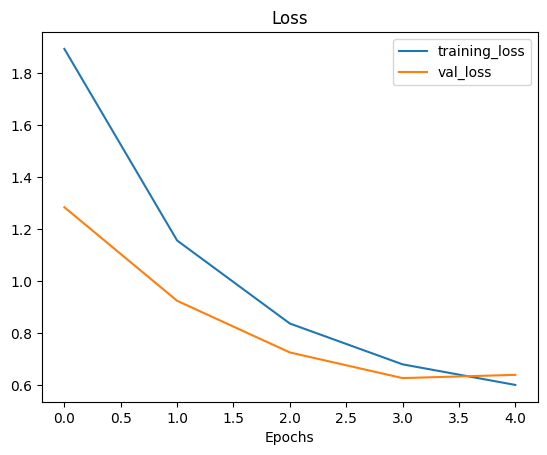

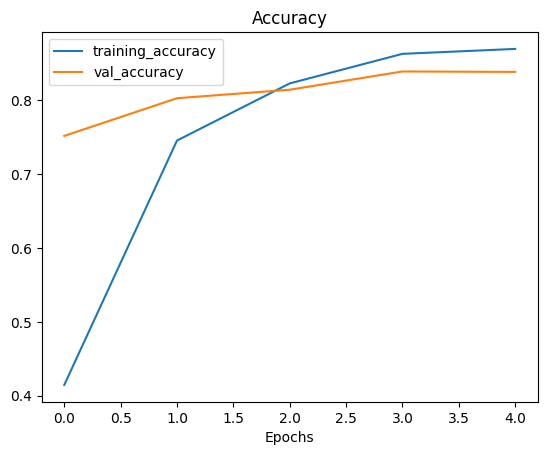

In [16]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [17]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [18]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same as the above cell but for [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

In [19]:
# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global maxed pooled input tensor: {global_max_pooled_tensor.shape}")

# Reproduce the same result using reduce_max
reproduce_max = tf.reduce_max(input_tensor, axis=[1, 2]) # take the max across the middle axes
print(f"Reproduced max as global max pooled tensor:\n {reproduce_max}\n") # will be the same as GlobalMaxPool2D()

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global maxed pooled input tensor: (1, 3)
Reproduced max as global max pooled tensor:
 [[0.9058464 1.1603122 1.6994323]]



## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

| Experiment | Data | Preprocessing | Model |
|------------|------|---------------|-------|
| Model 0 (baseline) | 10 classes of Food101 data (random 10% training data only) | None | Feature Extractor: EfficientNetB0 (pre-trained on ImageNet, all layers frozen) with no top |
| Model 1 | 10 classes of Food101 data (random 1% training data only) | Random Flip, Rotation, Zoom, Height, Width data augmentation | Same as Model 0 |
| Model 2 | Same as Model 0 | Same as Model 1 | Same as Model 0 |
| Model 3 | Same as Model 0 | Same as Model 1 | Fine-tuning: Model 2 (EfficientNetB0 pre-trained on ImageNet) with top layer trained on custom data, top 10 layers unfrozen |
| Model 4 | 10 classes of Food101 data (100% training data) | Same as Model 1 | Same as Model 3 |

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the **same test dataset**, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetV2B0` model within the `tf.keras.applications.efficientnet_v2` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [20]:
# Download and unzip data (skip, load the data locally)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
image_data_dir = "data/image_data/"
train_dir_1_percent = image_data_dir + "10_food_classes_1_percent/train/"
test_dir = image_data_dir + "10_food_classes_1_percent/test/"

In [21]:
# Walk through 1 percent data directory and list number of files
walk_through_dir(train_dir_1_percent)

There are 10 directories and 0 images in 'data/image_data/10_food_classes_1_percent/train/'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/stea

Alright, looks like we've only got seven images of each class, this should be a bit of a challenge for our model.

> 🔑 **Note:** As with the 10% of data subset, the 1% of images were chosen at random from the original full training dataset. The test images are the same as the ones which have previously been used. If you want to see how this data was preprocessed, check out the [Food Vision Image Preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

Time to load our images in as `tf.data.Dataset` objects, to do so, we'll use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) method.

In [22]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    batch_size=32,  # default
    image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> 📚 **Resource:** For more information on different methods of data augmentation, check out the the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) - flips image on horizontal or vertical axis.
* [`tf.keras.layersRandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) - randomly rotates image by a specified amount.
* [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) - randomly zooms into an image by specified amount.
* [`tf.keras.layers.RandomHeight`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight) - randomly shifts image height by a specified amount.
* [`tf.keras.layers.RandomWidth`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth) - randomly shifts image width by a specified amount.
* [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using [`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0), it's not required (the model pretrained model implements rescaling itself).

There are more option but these will do for now.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),
        # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
    ],
    name="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

And that's it! Our data augmentation Sequential model is ready to go.

As you'll see shortly, we'll be able to slot this "model" as a layer into our transfer learning model later on.

But before we do that, let's test it out by passing random images through it.

(-0.5, 604.5, 431.5, -0.5)

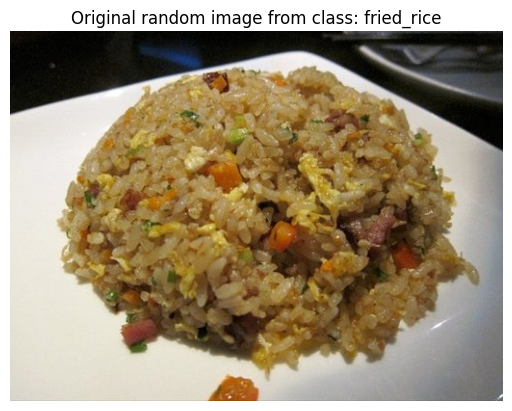

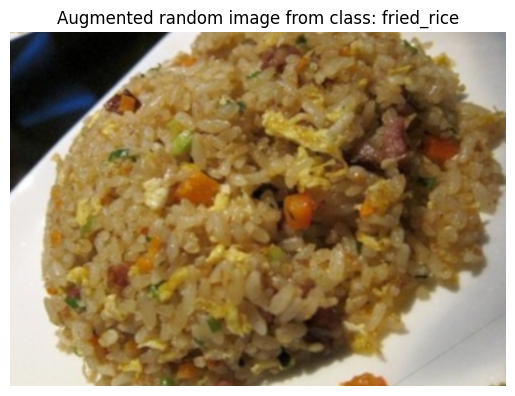

In [24]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)  # choose a random class
target_dir = train_dir_1_percent + target_class  # create the target directory
random_image = random.choice(os.listdir(target_dir))  # choose a random image from target directory
random_image_path = target_dir + "/" + random_image  # create the choosen random image path
img = mpimg.imread(random_image_path)  # read in the chosen target image
plt.imshow(img)  # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
# turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))  # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)  # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)


Run the cell above a few times and you can see the different random augmentations on different classes of images. Because we're going to add the data augmentation model as a layer in our upcoming transfer learning model, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")


# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(
    train_data_1_percent.repeat(),
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),  # validate for less steps
    # Track model training logs
    callbacks=[create_tensorboard_callback("1_percent_data_aug")])

Saving TensorBoard log files to: logs/transfer_learning_part_2/1_percent_data_aug
Epoch 1/5


W0000 00:00:1737856184.277084   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.351022   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.365629   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.444671   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.461921   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.476545   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.504811   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.527038   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856184.542539   41894 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.1250 - loss: 2.3538

W0000 00:00:1737856185.863780   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.865155   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.866270   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.867431   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.868576   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.869732   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.871238   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.872948   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856185.874529   41894 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.1094 - loss: 2.3778

W0000 00:00:1737856186.267243   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.268231   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.269270   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.270290   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.271331   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.272387   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.273407   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.274489   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856186.275566   41894 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.1110 - loss: 2.3779

W0000 00:00:1737856187.977727   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.979115   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.980439   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.981886   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.983335   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.984717   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.986421   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.988378   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856187.989931   41897 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1118 - loss: 2.3779 - val_accuracy: 0.1941 - val_loss: 2.2122
Epoch 2/5


W0000 00:00:1737856189.165834   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.167148   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.168253   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.169491   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.170652   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.171816   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.173296   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.174970   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.176505   41895 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - accuracy: 0.2188 - loss: 2.2518

W0000 00:00:1737856189.569598   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.592919   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.594221   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.595376   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.596578   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.597741   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.599046   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.600342   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856189.601532   41895 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.2734 - loss: 2.1983

W0000 00:00:1737856190.214124   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.215312   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.216226   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.216991   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.217781   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.218593   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.219541   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.220423   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.222263   41887 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.2918 - loss: 2.1758

W0000 00:00:1737856190.422270   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.423027   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.423798   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.424636   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.425464   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.426247   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.427032   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.427789   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856190.428569   41887 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 710ms/step - accuracy: 0.3010 - loss: 2.1646 - val_accuracy: 0.2237 - val_loss: 2.1789
Epoch 3/5


W0000 00:00:1737856191.112439   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.113622   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.114713   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.115899   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.117002   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.118098   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.119414   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.121003   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.122307   41899 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.2500 - loss: 1.9985

W0000 00:00:1737856191.584815   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.586174   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.587292   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.588660   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.589983   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.591284   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.593237   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.595400   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856191.597113   41889 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.2656 - loss: 1.9674

W0000 00:00:1737856192.199120   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.200780   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.202133   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.204018   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.205543   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.207260   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.209008   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.211160   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.213347   41889 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.2818 - loss: 1.9555

W0000 00:00:1737856192.400243   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.401087   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.401877   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.402637   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.403354   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.404134   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.404826   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.405579   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856192.406333   41890 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step - accuracy: 0.2900 - loss: 1.9496 - val_accuracy: 0.3076 - val_loss: 2.0563
Epoch 4/5


W0000 00:00:1737856193.188264   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.189823   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.190955   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.192262   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.193564   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.194861   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.196732   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.198852   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.200495   41889 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - accuracy: 0.4062 - loss: 1.8546

W0000 00:00:1737856193.642002   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.666586   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.667874   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.669060   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.670378   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.671499   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.672796   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.674034   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856193.675158   41889 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.4062 - loss: 1.8541

W0000 00:00:1737856194.275836   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.277007   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.278077   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.279251   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.280283   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.281428   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.282601   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.283898   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.285455   41896 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.4042 - loss: 1.8528

W0000 00:00:1737856194.478458   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.479533   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.480747   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.481987   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.483145   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.484156   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.485199   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.486186   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856194.487350   41895 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step - accuracy: 0.4031 - loss: 1.8522 - val_accuracy: 0.3586 - val_loss: 1.9441
Epoch 5/5


W0000 00:00:1737856195.317973   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.319273   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.320387   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.321717   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.322996   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.324288   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.326056   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.328130   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.329807   41896 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step - accuracy: 0.5000 - loss: 1.6906

W0000 00:00:1737856195.767695   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.791862   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.793050   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.794277   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.795594   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.796709   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.797963   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.799342   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856195.800529   41896 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.4922 - loss: 1.7048

W0000 00:00:1737856196.400130   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.402817   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.429553   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.431005   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.432278   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.433461   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.434602   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.435791   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.437071   41894 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.4900 - loss: 1.7095

W0000 00:00:1737856196.601768   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.602794   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.603706   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.604741   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.605868   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.607006   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.608063   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.609411   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856196.610648   41886 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 630ms/step - accuracy: 0.4890 - loss: 1.7119 - val_accuracy: 0.3824 - val_loss: 1.9173


2025-01-26 09:49:57.085571: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Wow!

How cool is that? Using only 7 training images per class, using transfer learning our model was able to get ~45%+ accuracy on the validation set.

This result is pretty amazing since the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved 50.67% accuracy with all the data, namely, 750 training images per class (**note:** this metric was across 101 classes, not 10, we'll get to 101 classes soon).

If we check out a summary of our model, we should see the data augmentation layer just after the input layer.

In [26]:
# Check out model summary
model_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [27]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3996 - loss: 1.8707


[1.8766558170318604, 0.3959999978542328]

The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line `validation_steps=int(0.25 * len(test_data))`. Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.

Let's stay consistent and check out our model's loss curves.

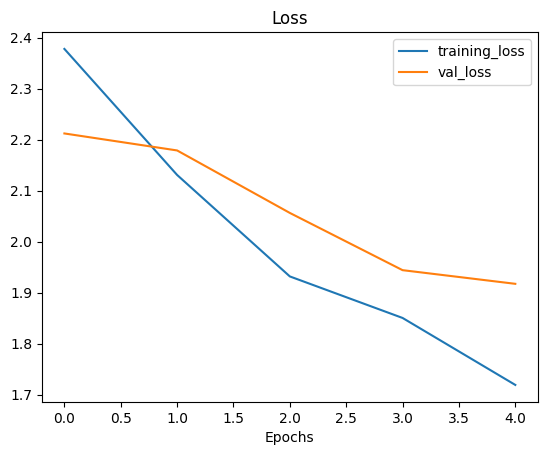

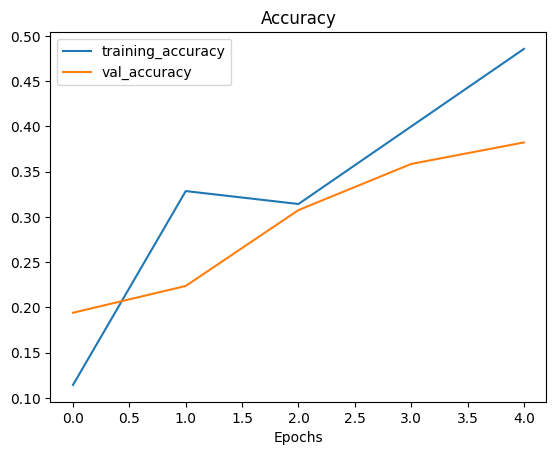

In [28]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But we'll leave that for now, we've got more experiments to do!

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

But wait...

> 🤔 **Question:** How do you know what experiments to run?

Great question.

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [29]:
food_classes_dir = "data/image_data/10_food_classes_10_percent"
train_dir_10_percent = food_classes_dir + "/train/"
test_dir = food_classes_dir + "/test/"

In [30]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Awesome!

We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [31]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),
        # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
    ],
    name="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer")  # create input layer
x = data_augmentation(inputs)  # augment our training images
x = base_model(
    x, training=False
)  # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # use Adam optimizer with base learning rate
    metrics=["accuracy"])

In [32]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

    return model


# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [33]:
model_2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [34]:
# Setup checkpoint path
checkpoint_path = "logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # set to False to save the entire model
    save_best_only=True,  # save only the best model weights instead of a model every epoch
    save_freq="epoch",  # save every epoch
    verbose=1)

> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [35]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),  # do less steps per validation (quicker)
    callbacks=[create_tensorboard_callback("10_percent_data_aug"), checkpoint_callback])

Saving TensorBoard log files to: logs/transfer_learning_part_2/10_percent_data_aug
Epoch 1/5


W0000 00:00:1737856209.967723   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856209.988171   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.003127   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.022587   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.041746   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.057685   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.082918   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.108249   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.124780   41895 gp

 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:31 7s/step - accuracy: 0.1875 - loss: 2.3916

W0000 00:00:1737856210.938025   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.939350   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.940406   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.941607   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.942759   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.943920   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.945409   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.947097   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856210.948544   41886 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 12s 548ms/step - accuracy: 0.1641 - loss: 2.3828

W0000 00:00:1737856211.342781   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.370710   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.371916   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.373016   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.374197   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.375359   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.376543   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.377881   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.379254   41886 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 12s 590ms/step - accuracy: 0.1684 - loss: 2.3622

W0000 00:00:1737856211.987484   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.988735   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.990002   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.991420   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.992745   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.994111   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.995540   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.996954   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856211.998236   41885 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 11s 557ms/step - accuracy: 0.1673 - loss: 2.3442

W0000 00:00:1737856212.393775   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.396071   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.399125   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.402713   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.446829   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.457958   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.459138   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.460249   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856212.461500   41895 gp

 5/24 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - accuracy: 0.1664 - loss: 2.3344

W0000 00:00:1737856213.007789   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.008780   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.009911   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.011019   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.012026   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.013149   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.014253   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.015346   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.016521   41895 gp

 6/24 ━━━━━━━━━━━━━━━━━━━━ 10s 579ms/step - accuracy: 0.1699 - loss: 2.3252

W0000 00:00:1737856213.635578   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.637033   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.638312   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.639772   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.640927   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.642264   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.643516   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.644606   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856213.645680   41897 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 10s 597ms/step - accuracy: 0.1711 - loss: 2.3198

W0000 00:00:1737856214.288315   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.312208   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.313337   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.314592   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.315958   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.317077   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.318246   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.319401   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.320506   41886 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 9s 591ms/step - accuracy: 0.1722 - loss: 2.3144 

W0000 00:00:1737856214.928241   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.929623   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.930677   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.931827   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.933039   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.934028   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.935160   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.936257   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856214.938745   41894 gp

 9/24 ━━━━━━━━━━━━━━━━━━━━ 8s 596ms/step - accuracy: 0.1743 - loss: 2.3079

W0000 00:00:1737856215.532872   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.534034   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.535583   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.537059   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.538158   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.539221   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.540439   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.541500   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856215.542733   41898 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 8s 586ms/step - accuracy: 0.1769 - loss: 2.3006

W0000 00:00:1737856216.136868   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.138270   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.139977   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.141605   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.143224   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.144818   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.203604   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.204790   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.205919   41895 gp

11/24 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - accuracy: 0.1799 - loss: 2.2928

W0000 00:00:1737856216.547949   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.558289   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.559398   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.560512   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.561632   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.562604   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.563664   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.564785   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856216.565741   41895 gp

12/24 ━━━━━━━━━━━━━━━━━━━━ 6s 572ms/step - accuracy: 0.1833 - loss: 2.2852

W0000 00:00:1737856217.154732   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.156959   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.162879   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.221824   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.223012   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.224248   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.225406   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.226574   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.227729   41898 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - accuracy: 0.1864 - loss: 2.2782

W0000 00:00:1737856217.563324   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.574686   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.575871   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.576946   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.578082   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.579075   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.580122   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.581440   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.582514   41898 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.1903 - loss: 2.2701

W0000 00:00:1737856217.765581   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.768370   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.772271   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.775882   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.779470   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.784541   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.786593   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.791598   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856217.796227   41895 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 4s 535ms/step - accuracy: 0.1935 - loss: 2.2630

W0000 00:00:1737856218.429023   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.430128   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.431105   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.432211   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.433295   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.434406   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.435702   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.437133   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.438425   41895 gp

16/24 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.1969 - loss: 2.2557

W0000 00:00:1737856218.877797   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.879418   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.880653   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.881978   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.883422   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.884810   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.886555   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.888550   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856218.890117   41895 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - accuracy: 0.2009 - loss: 2.2480

W0000 00:00:1737856219.289022   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.300426   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.301621   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.302748   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.303949   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.304982   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.306128   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.307399   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.308442   41895 gp

18/24 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - accuracy: 0.2050 - loss: 2.2407

W0000 00:00:1737856219.894288   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.895432   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.897620   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.927344   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.928512   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.929702   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.930978   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.932222   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856219.933472   41893 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.2095 - loss: 2.2331

W0000 00:00:1737856220.513091   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.514407   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.515653   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.516972   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.518033   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.519203   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.520415   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.521555   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856220.522652   41895 gp

20/24 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.2141 - loss: 2.2254

W0000 00:00:1737856221.121054   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.122245   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.123361   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.124624   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.125669   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.126889   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.128092   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.129133   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.130157   41892 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 0.2186 - loss: 2.2180

W0000 00:00:1737856221.527370   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.529704   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.531667   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.534170   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.536864   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.570212   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.579957   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.581025   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856221.582008   41892 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - accuracy: 0.2232 - loss: 2.2106

W0000 00:00:1737856222.143278   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.144876   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.146493   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.148217   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.149946   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.205425   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.206573   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.207571   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.208752   41894 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.2276 - loss: 2.2033

W0000 00:00:1737856222.565615   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.589635   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.590749   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.591874   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.593084   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.594074   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.595213   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.596346   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.597436   41894 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.2318 - loss: 2.1964

W0000 00:00:1737856222.968920   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.969934   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.970865   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.971877   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.972850   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.973856   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.974717   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.975591   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856222.976649   41885 gp


Epoch 1: val_loss improved from inf to 1.50253, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - accuracy: 0.2357 - loss: 2.1900 - val_accuracy: 0.6316 - val_loss: 1.5025
Epoch 2/5


W0000 00:00:1737856225.706572   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.707978   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.709282   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.710691   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.712115   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.713544   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.715379   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.717707   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856225.719332   41891 gp

 1/24 ━━━━━━━━━━━━━━━━━━━━ 14s 632ms/step - accuracy: 0.5625 - loss: 1.6529

W0000 00:00:1737856226.121068   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.131278   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.132490   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.133641   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.134849   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.135998   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.137214   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.138393   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.139485   41891 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 13s 593ms/step - accuracy: 0.5312 - loss: 1.6751

W0000 00:00:1737856226.725854   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.727042   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.728293   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.729330   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.730445   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.731703   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.732809   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.734049   41893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856226.735073   41893 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step - accuracy: 0.5347 - loss: 1.6675 

W0000 00:00:1737856227.200510   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.201756   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.202824   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.203992   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.205143   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.206419   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.207952   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.209626   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.211052   41890 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - accuracy: 0.5475 - loss: 1.6574

W0000 00:00:1737856227.604021   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.630990   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.632271   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.633475   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.634666   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.635822   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.637046   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.638305   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856227.639494   41890 gp

 5/24 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.5580 - loss: 1.6496

W0000 00:00:1737856228.209039   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.210316   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.211501   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.212696   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.213922   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.215011   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.216348   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.217541   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.218855   41885 gp

 6/24 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step - accuracy: 0.5614 - loss: 1.6455

W0000 00:00:1737856228.631352   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.641381   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.642551   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.643564   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.644708   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.645623   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.646630   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.647789   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856228.648837   41895 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 8s 510ms/step - accuracy: 0.5634 - loss: 1.6401

W0000 00:00:1737856229.255061   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.256340   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.257497   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.258742   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.259783   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.260936   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.262232   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.263301   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.264326   41885 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 8s 505ms/step - accuracy: 0.5653 - loss: 1.6335

W0000 00:00:1737856229.689765   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.700260   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.701323   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.702447   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.703561   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.704555   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.705642   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.706675   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856229.707649   41885 gp

 9/24 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step - accuracy: 0.5665 - loss: 1.6276

W0000 00:00:1737856230.102394   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.139204   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.150275   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.151445   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.152459   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.153550   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.154485   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.155512   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.156533   41892 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 7s 504ms/step - accuracy: 0.5677 - loss: 1.6221

W0000 00:00:1737856230.706321   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.707526   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.710300   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.734736   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.735882   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.737027   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.738182   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.739401   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.740647   41890 gp

11/24 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.5695 - loss: 1.6161

W0000 00:00:1737856230.963592   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.964859   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.965900   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.967162   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.968248   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.969403   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.970716   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.972190   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856230.973704   41895 gp

12/24 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - accuracy: 0.5705 - loss: 1.6109

W0000 00:00:1737856231.415506   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.418451   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.419910   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.421236   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.422528   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.423916   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.425532   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.427434   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.428955   41890 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step - accuracy: 0.5713 - loss: 1.6058

W0000 00:00:1737856231.849790   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.850965   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.852167   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.853397   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.854442   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.855601   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.856705   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.857725   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856231.858724   41890 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 4s 483ms/step - accuracy: 0.5729 - loss: 1.6006

W0000 00:00:1737856232.481712   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.482990   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.484199   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.485379   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.486574   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.487803   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.489284   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.490600   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.491780   41895 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - accuracy: 0.5742 - loss: 1.5955

W0000 00:00:1737856232.904186   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.914520   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.915730   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.916954   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.918035   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.919016   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.920117   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.921174   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856232.922125   41885 gp

16/24 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.5756 - loss: 1.5905

W0000 00:00:1737856233.570151   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.571304   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.572233   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.573253   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.574227   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.575245   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.576523   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.577872   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.579047   41886 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 0.5769 - loss: 1.5852

W0000 00:00:1737856233.771317   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.772577   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.773784   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.774960   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.776403   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.777743   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.779121   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.780332   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856233.781966   41886 gp

18/24 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.5782 - loss: 1.5801

W0000 00:00:1737856234.409041   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.414997   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.485485   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.510060   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.511307   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.512507   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.513806   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.515296   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856234.516782   41895 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - accuracy: 0.5796 - loss: 1.5750

W0000 00:00:1737856235.040950   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.042005   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.043268   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.044399   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.046658   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.075265   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.076589   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.077820   41891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.079121   41891 gp

20/24 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 0.5810 - loss: 1.5703

W0000 00:00:1737856235.714998   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.716355   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.717603   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.718862   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.720173   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.721465   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.722868   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.724229   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856235.725441   41894 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - accuracy: 0.5822 - loss: 1.5660

W0000 00:00:1737856236.321615   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.322791   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.324210   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.325510   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.326969   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.328129   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.329286   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.330702   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.332496   41898 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5835 - loss: 1.5617

W0000 00:00:1737856236.804158   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.805650   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.806825   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.808218   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.809582   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.810925   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.813013   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.815405   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856236.817246   41880 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.5850 - loss: 1.5571

W0000 00:00:1737856237.421019   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.422804   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.424095   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.425418   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.427020   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.428779   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.430392   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.431735   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.433173   41880 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.5864 - loss: 1.5526

W0000 00:00:1737856237.824284   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.825406   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.826362   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.827954   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.847171   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.848144   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.849067   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.850077   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856237.850953   41892 gp


Epoch 2: val_loss improved from 1.50253 to 1.13675, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 559ms/step - accuracy: 0.5878 - loss: 1.5485 - val_accuracy: 0.6957 - val_loss: 1.1367
Epoch 3/5


W0000 00:00:1737856239.210283   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.211685   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.212803   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.214053   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.215312   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.216615   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.218055   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.219564   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.220917   41883 gp

 1/24 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.4375 - loss: 1.4871

W0000 00:00:1737856239.427002   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.428309   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.429762   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.431158   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.432577   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.433998   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.435643   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.437066   41883 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.438609   41883 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.5156 - loss: 1.4116 

W0000 00:00:1737856239.829552   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.830979   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.832671   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.834641   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.835950   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.837409   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.840193   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.911827   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856239.913010   41889 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.5590 - loss: 1.3704

W0000 00:00:1737856240.234657   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.235710   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.236719   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.237808   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.238754   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.239788   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.240804   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.241718   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.242687   41889 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.5794 - loss: 1.3535

W0000 00:00:1737856240.665786   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.676965   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.678353   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.679467   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.680603   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.681742   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.682823   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.683930   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856240.685030   41889 gp

 5/24 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - accuracy: 0.5973 - loss: 1.3351

W0000 00:00:1737856241.291354   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.292510   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.293602   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.295042   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.296161   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.297330   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.298532   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.299616   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.300681   41896 gp

 6/24 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - accuracy: 0.6071 - loss: 1.3212

W0000 00:00:1737856241.712380   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.713744   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.715115   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.716498   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.717815   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.719106   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.720792   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.722256   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856241.723835   41887 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - accuracy: 0.6167 - loss: 1.3083

W0000 00:00:1737856242.127432   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.128794   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.130054   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.131352   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.132635   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.133917   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.135489   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.136939   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.138438   41880 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - accuracy: 0.6211 - loss: 1.3003

W0000 00:00:1737856242.748975   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.750187   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.751375   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.752674   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.753771   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.754951   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.756243   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.757306   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856242.758337   41892 gp

 9/24 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - accuracy: 0.6243 - loss: 1.2942

W0000 00:00:1737856243.408828   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.410082   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.411206   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.412592   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.413824   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.415054   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.416780   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.418638   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.420208   41886 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - accuracy: 0.6256 - loss: 1.2893

W0000 00:00:1737856243.821665   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.822788   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.823902   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.825146   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.826260   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.827437   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.828601   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.829640   41886 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856243.830714   41886 gp

11/24 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - accuracy: 0.6268 - loss: 1.2850

W0000 00:00:1737856244.254747   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.264788   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.265876   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.266916   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.268223   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.269244   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.270291   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.271443   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.272431   41882 gp

12/24 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - accuracy: 0.6286 - loss: 1.2793

W0000 00:00:1737856244.863530   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.864721   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.865878   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.867501   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.868978   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.870054   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.871079   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.872334   41892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856244.873350   41892 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - accuracy: 0.6306 - loss: 1.2742

W0000 00:00:1737856245.272550   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.277316   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.329287   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.339324   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.340670   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.341738   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.342907   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.343931   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.345041   41881 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - accuracy: 0.6321 - loss: 1.2697

W0000 00:00:1737856245.675647   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.678656   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.680275   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.682914   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.685499   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.687582   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.690180   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.693424   41890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856245.730771   41890 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - accuracy: 0.6336 - loss: 1.2654

W0000 00:00:1737856246.279844   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.280967   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.282082   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.283222   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.284434   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.285680   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.286996   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.288205   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.289240   41899 gp

16/24 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.6351 - loss: 1.2610

W0000 00:00:1737856246.683251   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.686357   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.690876   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.742919   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.753036   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.754150   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.755216   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.756378   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856246.757372   41880 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.6368 - loss: 1.2561

W0000 00:00:1737856247.316549   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.317908   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.319110   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.320511   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.321776   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.323552   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.324831   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.326142   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.327599   41899 gp

18/24 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.6379 - loss: 1.2520

W0000 00:00:1737856247.721333   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.723579   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.727506   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.729518   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.732890   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.736304   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.739139   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.742783   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856247.747577   41880 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.6389 - loss: 1.2484

W0000 00:00:1737856248.167797   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.168988   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.170025   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.171136   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.172221   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.173411   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.174699   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.176198   41899 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.177477   41899 gp

20/24 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.6399 - loss: 1.2454

W0000 00:00:1737856248.406932   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.408181   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.409223   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.410412   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.411587   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.412757   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.414250   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.415914   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.417377   41880 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - accuracy: 0.6409 - loss: 1.2425

W0000 00:00:1737856248.608072   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.609671   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.611370   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.612642   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.614063   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.616761   41880 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.680877   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.682187   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856248.683275   41887 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.6420 - loss: 1.2395

W0000 00:00:1737856249.258817   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.260006   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.261067   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.262390   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.263614   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.264878   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.266514   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.268402   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.270043   41897 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6430 - loss: 1.2371

W0000 00:00:1737856249.693483   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.694715   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.695798   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.696957   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.698037   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.699156   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.700334   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.701423   41897 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856249.702445   41897 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6440 - loss: 1.2349

W0000 00:00:1737856250.105202   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.124389   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.125434   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.126298   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.127138   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.127994   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.128843   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.129723   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856250.130621   41878 gp


Epoch 3: val_loss improved from 1.13675 to 0.84140, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 514ms/step - accuracy: 0.6449 - loss: 1.2328 - val_accuracy: 0.7944 - val_loss: 0.8414
Epoch 4/5


W0000 00:00:1737856251.478429   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.479870   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.481074   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.482414   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.483736   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.485043   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.486688   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.488522   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.490094   41884 gp

 1/24 ━━━━━━━━━━━━━━━━━━━━ 11s 516ms/step - accuracy: 0.6562 - loss: 1.1763

W0000 00:00:1737856251.882202   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.883200   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.884372   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.885487   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.888130   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.954574   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.955812   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.956935   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856251.958198   41884 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step - accuracy: 0.6797 - loss: 1.1462 

W0000 00:00:1737856252.289303   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.299127   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.300173   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.301196   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.302412   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.303462   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.304514   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.305584   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.306541   41884 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - accuracy: 0.6997 - loss: 1.1181

W0000 00:00:1737856252.922208   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.923653   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.924999   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.926321   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.927628   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.928931   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.930330   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.931711   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856252.933135   41884 gp

 5/24 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.7157 - loss: 1.0984 

W0000 00:00:1737856253.619918   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.621237   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.622283   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.623428   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.624534   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.625680   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.627085   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.628652   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.629985   41898 gp

 6/24 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step - accuracy: 0.7197 - loss: 1.0904

W0000 00:00:1737856253.850585   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.852095   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.853431   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.854721   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.855980   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.857231   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.858847   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.860282   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856253.861834   41898 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.7259 - loss: 1.0787

W0000 00:00:1737856254.524243   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.525732   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.526945   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.528270   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.529532   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.530829   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.532557   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.534542   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.536246   41885 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.7299 - loss: 1.0706

W0000 00:00:1737856254.950091   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.973548   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.974666   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.975790   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.977026   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.978069   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.979239   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.980402   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856254.981454   41885 gp

 9/24 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.7333 - loss: 1.0650

W0000 00:00:1737856255.575878   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.577344   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.578472   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.579672   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.580823   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.582055   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.583224   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.584304   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856255.585391   41888 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - accuracy: 0.7356 - loss: 1.0606

W0000 00:00:1737856256.179735   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.180775   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.181839   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.182963   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.184083   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.185121   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.186306   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.187404   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.188541   41888 gp

11/24 ━━━━━━━━━━━━━━━━━━━━ 6s 502ms/step - accuracy: 0.7374 - loss: 1.0573

W0000 00:00:1737856256.789767   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.790908   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.792054   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.793497   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.794656   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.796012   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.797230   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.798310   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856256.799382   41895 gp

12/24 ━━━━━━━━━━━━━━━━━━━━ 6s 511ms/step - accuracy: 0.7391 - loss: 1.0531

W0000 00:00:1737856257.396834   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.398044   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.399200   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.400448   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.401563   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.402848   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.404033   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.405105   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856257.406180   41895 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - accuracy: 0.7403 - loss: 1.0495

W0000 00:00:1737856258.015047   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.016466   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.018121   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.019828   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.022022   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.028025   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.088234   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.089540   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.090618   41895 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - accuracy: 0.7409 - loss: 1.0463

W0000 00:00:1737856258.219411   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.221680   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.224262   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.230604   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.246489   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.276907   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.278276   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.279406   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.280576   41895 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.7409 - loss: 1.0439

W0000 00:00:1737856258.635257   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.636801   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.638204   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.639622   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.640993   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.642351   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.644065   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.645607   41882 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856258.647228   41882 gp

16/24 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.7410 - loss: 1.0413

W0000 00:00:1737856259.292074   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.316170   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.317513   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.318696   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.319959   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.321035   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.322215   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.323395   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.324596   41884 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.7411 - loss: 1.0394

W0000 00:00:1737856259.495163   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.497600   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.499461   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.502165   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.504623   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.507367   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.510093   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.512764   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856259.515062   41888 gp

18/24 ━━━━━━━━━━━━━━━━━━━━ 2s 490ms/step - accuracy: 0.7414 - loss: 1.0374

W0000 00:00:1737856260.119802   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.121115   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.122257   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.123456   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.124496   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.125751   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.126901   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.128002   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.129074   41888 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.7419 - loss: 1.0357

W0000 00:00:1737856260.736550   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.737686   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.738999   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.740248   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.741564   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.742946   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.744536   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.746166   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856260.747830   41889 gp

20/24 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step - accuracy: 0.7423 - loss: 1.0339

W0000 00:00:1737856261.193221   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.195291   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.196788   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.198259   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.199720   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.201182   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.202916   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.204896   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.206739   41885 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.7426 - loss: 1.0324

W0000 00:00:1737856261.616251   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.617553   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.618670   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.619924   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.621000   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.622164   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.623293   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.624334   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856261.625364   41885 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.7429 - loss: 1.0311

W0000 00:00:1737856262.242472   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.266146   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.267399   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.268583   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.269845   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.270905   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.272090   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.273313   41888 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856262.274403   41888 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7432 - loss: 1.0297

W0000 00:00:1737856263.078250   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.079795   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.081258   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.082627   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.084001   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.085435   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.087005   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.088559   41885 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.089952   41885 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7434 - loss: 1.0287

W0000 00:00:1737856263.491757   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.492808   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.493658   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.494601   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.495522   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.496375   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.497386   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.498531   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856263.499517   41896 gp


Epoch 4: val_loss improved from 0.84140 to 0.82738, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 560ms/step - accuracy: 0.7436 - loss: 1.0277 - val_accuracy: 0.7763 - val_loss: 0.8274
Epoch 5/5


W0000 00:00:1737856264.888857   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.890325   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.891560   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.892950   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.894357   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.895655   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.897400   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.899334   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856264.901205   41884 gp

 1/24 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.8125 - loss: 0.9082

W0000 00:00:1737856265.091619   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.093194   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.094650   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.096144   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.097444   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.098943   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.100383   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.101871   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.103200   41884 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.7812 - loss: 0.9246

W0000 00:00:1737856265.495628   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.498747   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.501853   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.504156   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.507532   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.511725   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.558917   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.570816   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856265.572099   41896 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 10s 513ms/step - accuracy: 0.7743 - loss: 0.9313

W0000 00:00:1737856266.106424   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.130888   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.132138   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.133338   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.134563   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.135593   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.136757   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.137919   41898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.138947   41898 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step - accuracy: 0.7604 - loss: 0.9504 

W0000 00:00:1737856266.543150   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.553377   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.554617   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.555640   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.556665   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.557631   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.558641   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.559650   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856266.560584   41896 gp

 5/24 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - accuracy: 0.7533 - loss: 0.9583

W0000 00:00:1737856267.148415   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.149606   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.150807   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.152138   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.153408   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.154695   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.156020   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.157096   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.158484   41881 gp

 6/24 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.7502 - loss: 0.9650

W0000 00:00:1737856267.590141   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.600188   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.601269   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.602272   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.603361   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.604306   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.605363   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.606408   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856267.607382   41895 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 8s 526ms/step - accuracy: 0.7482 - loss: 0.9686

W0000 00:00:1737856268.200570   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.201785   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.202974   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.204190   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.205766   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.207332   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.208468   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.209609   41894 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.210925   41894 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 8s 539ms/step - accuracy: 0.7480 - loss: 0.9691

W0000 00:00:1737856268.843207   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.866862   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.868096   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.869242   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.870510   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.871600   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.872788   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.873961   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856268.875054   41887 gp

 9/24 ━━━━━━━━━━━━━━━━━━━━ 8s 536ms/step - accuracy: 0.7470 - loss: 0.9696

W0000 00:00:1737856269.512802   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.514180   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.515411   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.516833   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.518134   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.519710   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.521414   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.523348   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.524961   41895 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accuracy: 0.7458 - loss: 0.9704

W0000 00:00:1737856269.731928   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.733508   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.734976   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.737154   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.738580   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.740103   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.741505   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.742969   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856269.744318   41895 gp

11/24 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 0.7449 - loss: 0.9700

W0000 00:00:1737856270.396950   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.398230   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.399376   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.400687   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.401884   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.403159   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.404837   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.406867   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.408428   41895 gp

12/24 ━━━━━━━━━━━━━━━━━━━━ 6s 520ms/step - accuracy: 0.7444 - loss: 0.9687

W0000 00:00:1737856270.813289   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.828129   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.829469   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.830807   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.832250   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.833433   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.834713   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.836006   41895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856270.837176   41895 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - accuracy: 0.7439 - loss: 0.9667

W0000 00:00:1737856271.218598   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.220830   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.223782   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.227316   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.272054   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.282288   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.283370   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.284418   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.285574   41884 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - accuracy: 0.7436 - loss: 0.9651

W0000 00:00:1737856271.665018   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.666349   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.667455   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.668747   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.670007   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.671256   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.672961   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.674922   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856271.676690   41881 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - accuracy: 0.7433 - loss: 0.9632

W0000 00:00:1737856272.086700   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.110147   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.111290   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.112444   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.113740   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.114919   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.116206   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.117374   41881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.118458   41881 gp

16/24 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - accuracy: 0.7435 - loss: 0.9612

W0000 00:00:1737856272.716324   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.739801   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.740956   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.742085   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.743281   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.744347   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.745513   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.746651   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856272.747718   41887 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.7436 - loss: 0.9593

W0000 00:00:1737856273.378589   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.379892   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.380975   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.382241   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.383382   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.384528   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.385920   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.387712   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.389085   41889 gp

18/24 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - accuracy: 0.7444 - loss: 0.9568

W0000 00:00:1737856273.806921   41889 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.870709   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.872189   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.873333   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.874618   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.875798   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.877040   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.878575   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856273.880351   41878 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step - accuracy: 0.7448 - loss: 0.9548

W0000 00:00:1737856274.262127   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.285741   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.286943   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.288101   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.289296   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.290320   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.291428   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.292576   41878 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.293595   41878 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - accuracy: 0.7453 - loss: 0.9513

W0000 00:00:1737856274.951240   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.952424   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.953470   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.954645   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.955800   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.957041   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.958574   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.960251   41884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856274.961682   41884 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7456 - loss: 0.9498

W0000 00:00:1737856275.403872   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.405009   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.406048   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.407238   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.408454   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.409684   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.411125   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.412747   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.414125   41896 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7460 - loss: 0.9482

W0000 00:00:1737856275.629159   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.630614   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.632166   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.634346   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.636018   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.637597   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.639311   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.640838   41896 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856275.642389   41896 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7464 - loss: 0.9465

W0000 00:00:1737856276.047013   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.056976   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.057981   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.058792   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.059604   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.060430   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.061254   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.062136   41887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737856276.062986   41887 gp


Epoch 5: val_loss improved from 0.82738 to 0.54879, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 512ms/step - accuracy: 0.7468 - loss: 0.9450 - val_accuracy: 0.8676 - val_loss: 0.5488


Would you look at that! Looks like our `ModelCheckpoint` callback worked and our model saved its weights every epoch without too much overhead (saving the whole model takes longer than just the weights).

Let's evaluate our model and check its loss curves.

In [36]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8209 - loss: 0.6904


[0.6843313574790955, 0.8227999806404114]

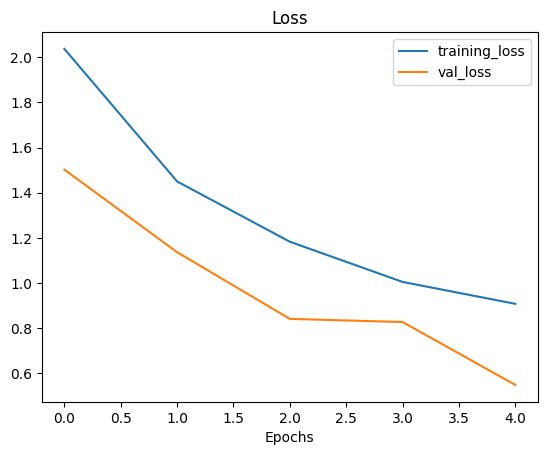

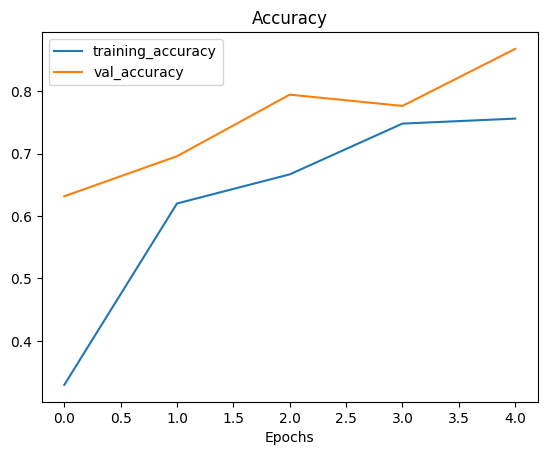

In [37]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

In [38]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8241 - loss: 0.6743


Now let's compare the results of our previously trained model and the loaded model. These results should very close if not exactly the same. The reason for minor differences comes down to the precision level of numbers calculated.

In [39]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [40]:
results_10_percent_data_aug, loaded_weights_model_results

([0.6843313574790955, 0.8227999806404114],
 [0.6843312978744507, 0.8227999806404114])

If the above cell doesn't output `True`, it's because the numbers are close but not the *exact* same (due to how computers store numbers with degrees of precision).

However, they should be *very* close...

In [41]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [42]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]
